In [62]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
device

device(type='cuda')

In [69]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.Country211(root=data_dir, download=True, transform=transform,split = "train"  )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',batch_size = 64,
                       augment = False, random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                              batch_size = 64)

Files already downloaded and verified
Files already downloaded and verified


In [70]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
num_classes = 10
num_epochs = 30
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


# Train the model
total_step = len(train_loader)

In [ ]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

In [ ]:
nombre_clases = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np


def pre_image(image_path,model, nombre_clases):
   img = Image.open(image_path)
   img.show()
   mean = [0.485, 0.456, 0.406]
   std = [0.229, 0.224, 0.225]

   transform_norm = transforms.Compose([transforms.ToTensor(),
   transforms.Resize((227,227)),transforms.Normalize(mean, std)])

   # get normalized image
   img_normalized = transform_norm(img).float()
   print("Dimensiones de raw image")
   print(img_normalized.shape)

   img_normalized = img_normalized.unsqueeze_(0)
   print("DImensiones de imagen unsqueeze")
   print(img_normalized.shape)

   # input = Variable(image_tensor)
   img_normalized = img_normalized.to(device)

   with torch.no_grad():
      model.eval()
      output =model(img_normalized)
      print("Salida de la red")
      print(output)
      index = output.data.cpu().numpy().argmax()
      class_name = nombre_clases[index]
      return class_name

In [ ]:
torch.save(model.state_dict(), "./model.pt")

In [ ]:
model_loaded = AlexNet()
model_loaded.to(device)
model_loaded.load_state_dict(torch.load('model.pt'))

c:\Users\AlfredoVanegas\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[13.5489, -0.0773,  3.0884, -1.4037, -2.3519, -2.7261, -4.7775, -0.7154,
         -2.1094, -2.4753]], device='cuda:0')
Clase predicha
Airplane


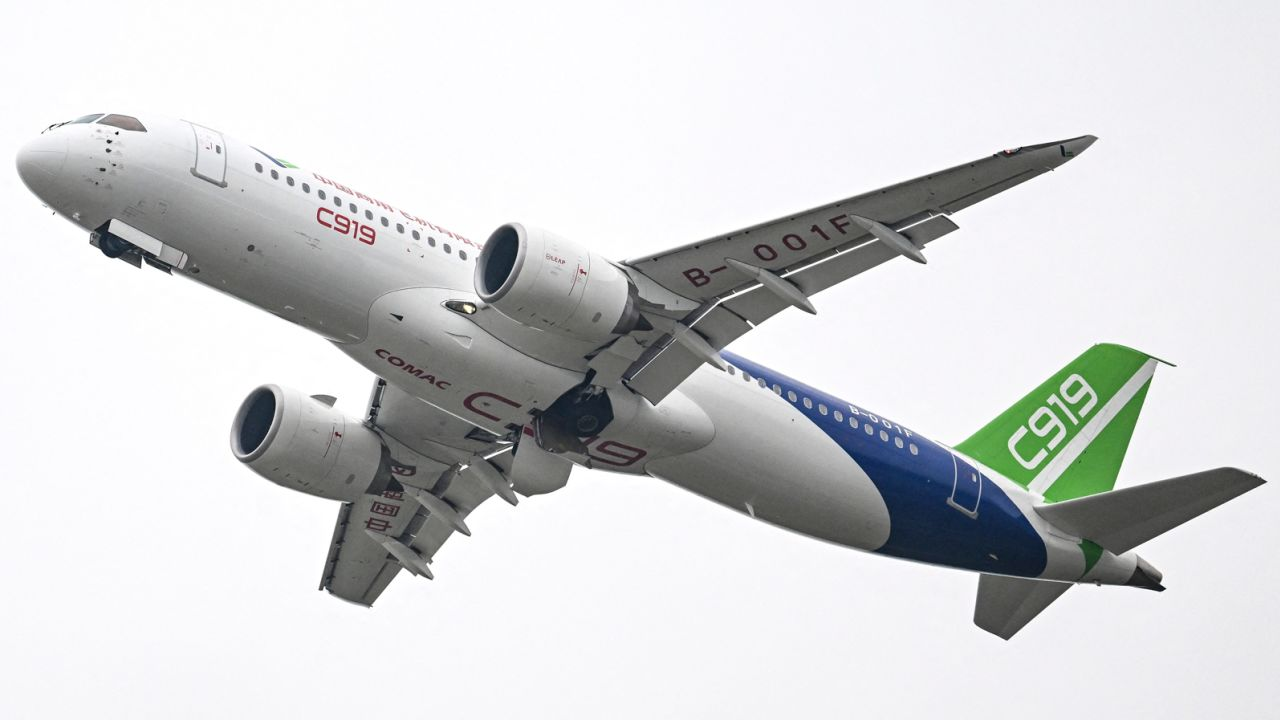

In [46]:
image_path = "./test/airplane.jpg"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))

Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[ 5.2812, -2.5725, 14.2645, -1.6298, -2.5123, -0.4781, -0.8895, -4.1557,
         -1.9402, -5.3698]], device='cuda:0')
Clase predicha
Bird


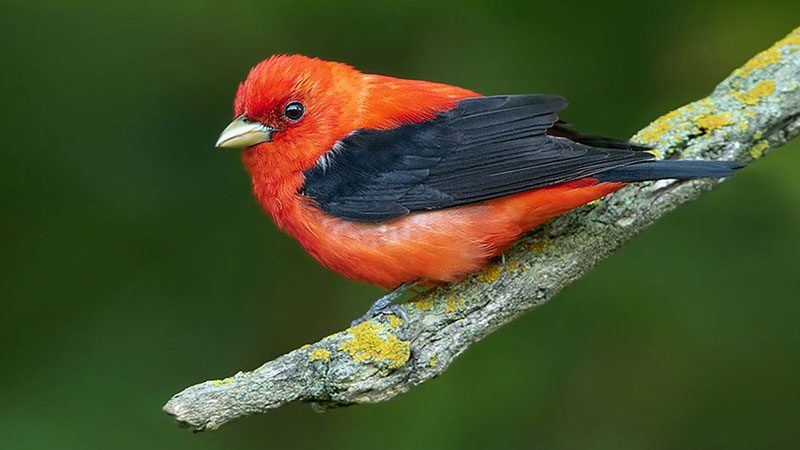

In [47]:
image_path = "./test/bird.jpg"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))

c:\Users\AlfredoVanegas\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[-0.7547, 19.7634, -4.2037, -2.8911, -5.5583, -4.0310, -2.9706, -5.4264,
          0.2048,  5.8644]], device='cuda:0')
Clase predicha
Automobile


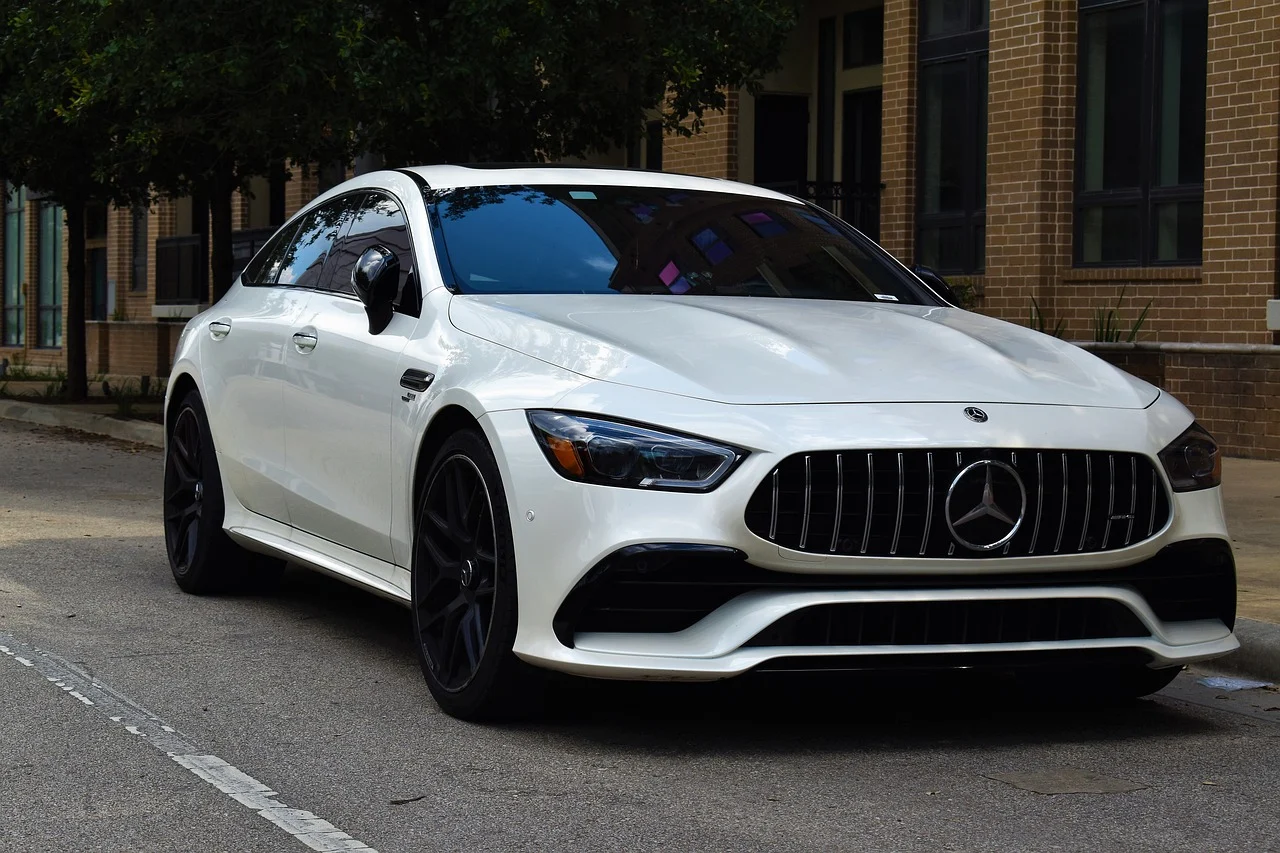

In [48]:
image_path = "./test/car.png"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))

Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[-2.3248, -3.5108, -0.2003,  0.6721, 11.8996,  0.3410, -0.4228, -0.2556,
         -3.3489, -2.8509]], device='cuda:0')
Clase predicha
Deer


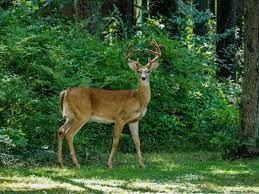

In [50]:
image_path = "./test/deer.jpg"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))

Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[-2.4265, -3.4218, -0.4405,  6.1673, -1.8585,  7.0055, -3.1301,  4.2490,
         -3.9469, -2.1985]], device='cuda:0')
Clase predicha
Dog


c:\Users\AlfredoVanegas\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


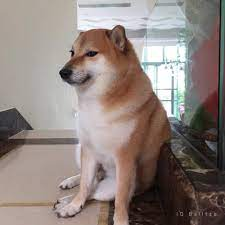

In [51]:
image_path = "./test/dog.jpg"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))

Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[ 1.8103,  0.7931, -2.2727, -2.4659, -3.1984, -2.9010, -1.4364, -4.0078,
         14.7681, -1.0889]], device='cuda:0')
Clase predicha
Ship


c:\Users\AlfredoVanegas\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


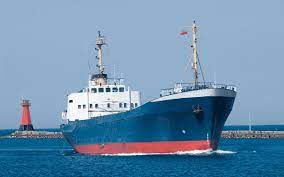

In [59]:
image_path = "./test/ship.jpg"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))

Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[-0.3712,  9.7031, -2.7481, -1.2308, -3.8283, -2.3482, -1.8437, -1.3954,
         -0.0283,  4.0898]], device='cuda:0')
Clase predicha
Automobile


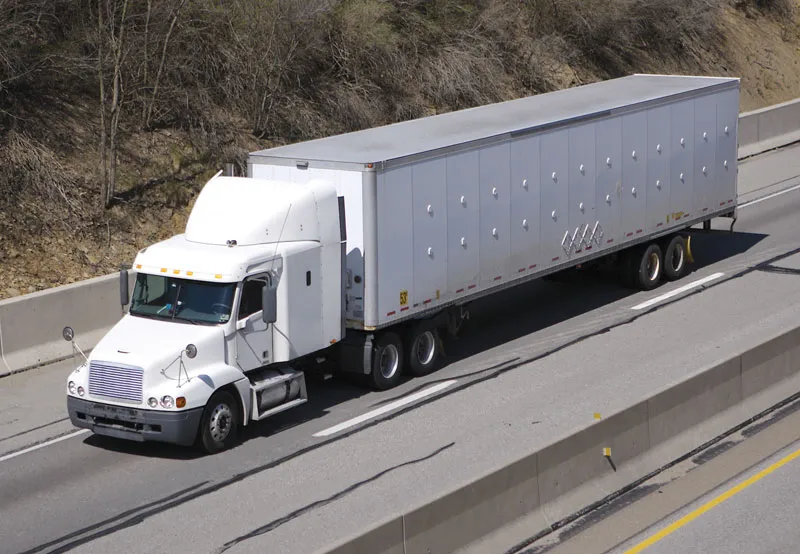

In [60]:
image_path = "./test/truck.png"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))

Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[-3.5421, -3.9865, -0.4792, 12.1191, -1.3618,  7.9909, -3.3442, -0.1009,
         -3.2703, -4.0268]], device='cuda:0')
Clase predicha
Cat


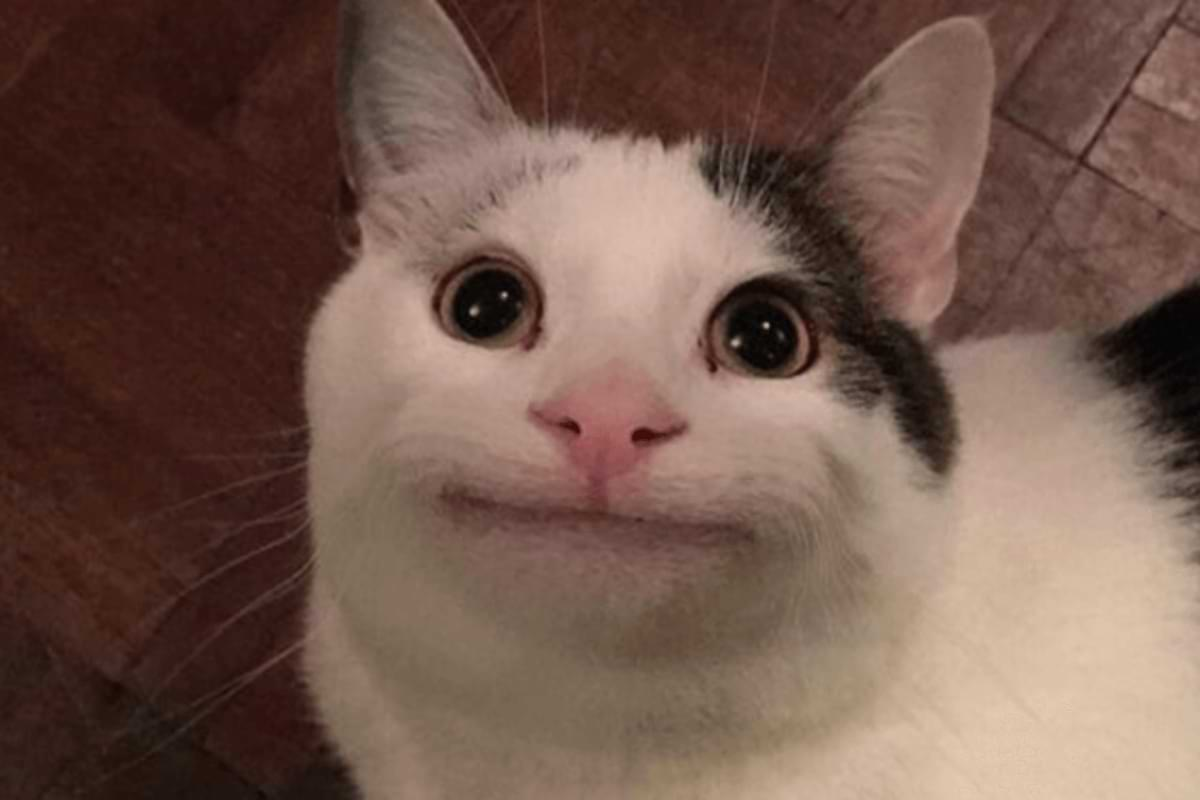

In [61]:
image_path = "./test/beluga.jpg"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))

c:\Users\AlfredoVanegas\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[ 1.0191, -2.3124, -0.6449,  5.6506,  1.0078, -0.8681, -1.4677, -1.7181,
          1.5823, -2.2486]], device='cuda:0')
Clase predicha
Cat


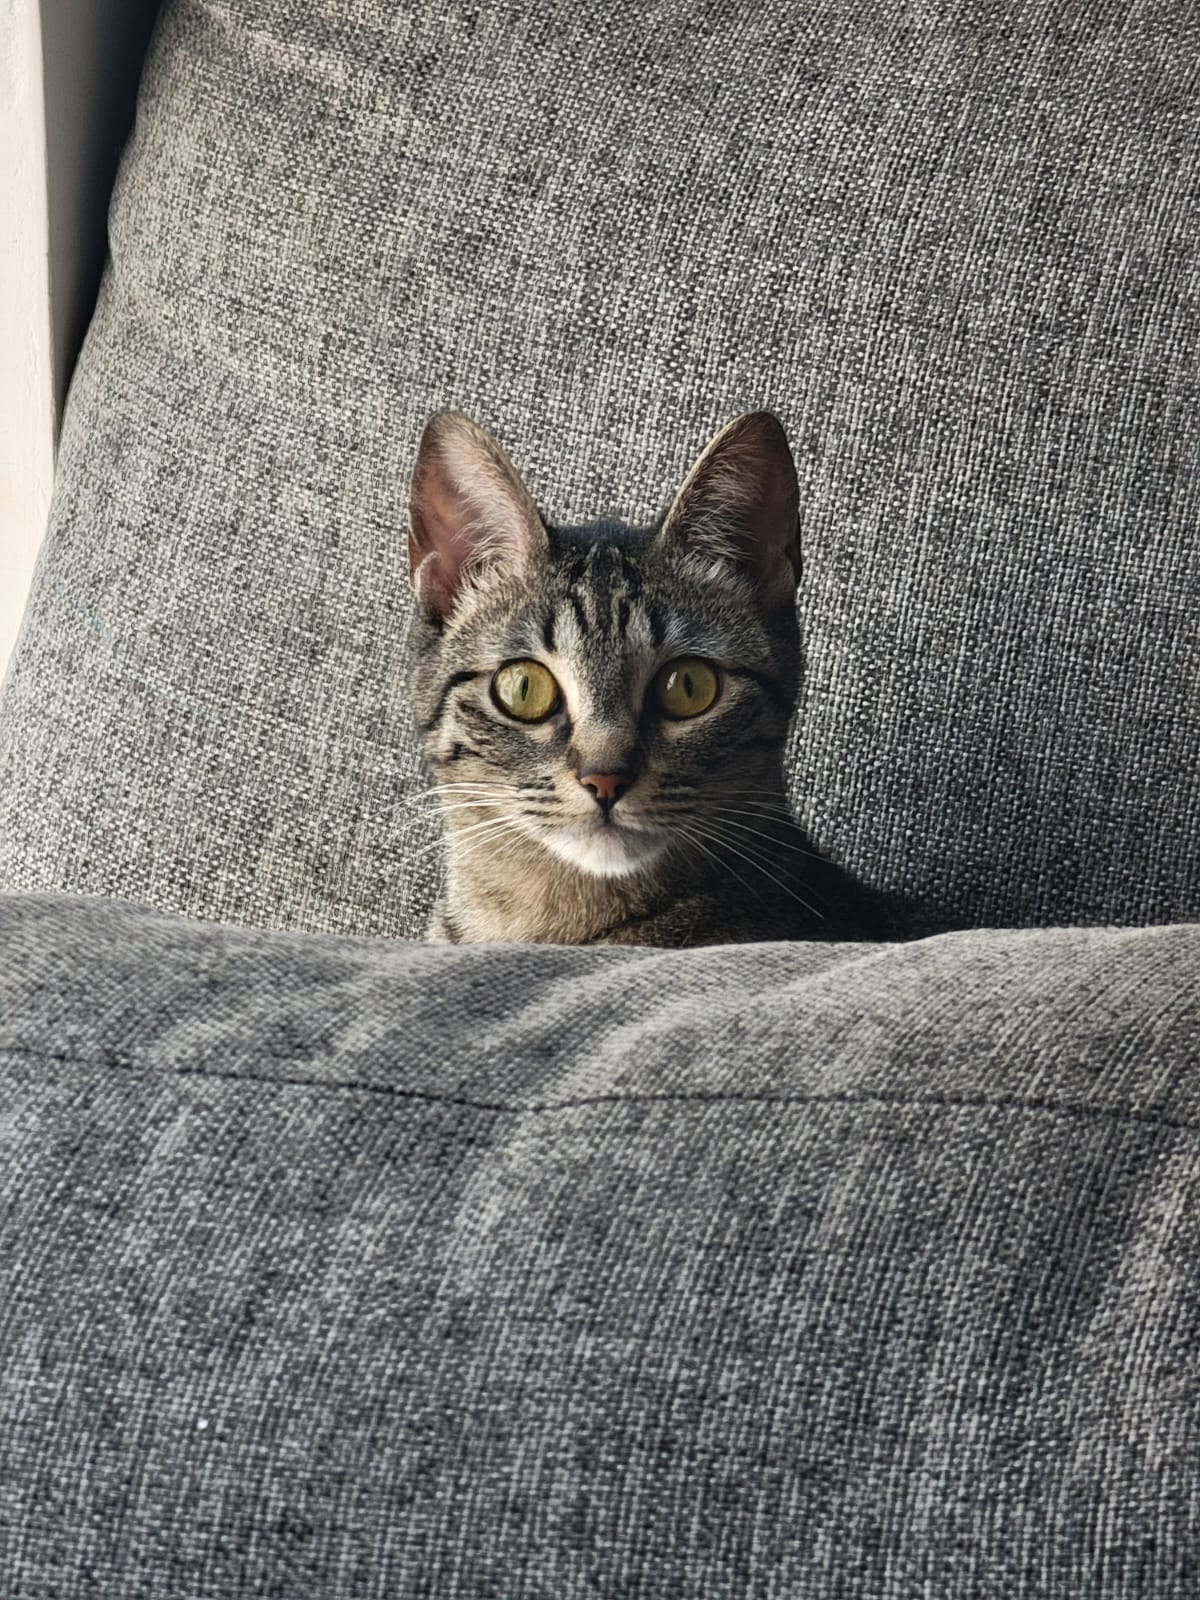

In [64]:
image_path = "./test/pagliacci_gato.jpg"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))

Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[-1.7681,  0.5850, -1.3561,  1.5966, -3.4286,  6.2590, -1.9996, -1.7336,
         -2.1962,  4.0404]], device='cuda:0')
Clase predicha
Dog


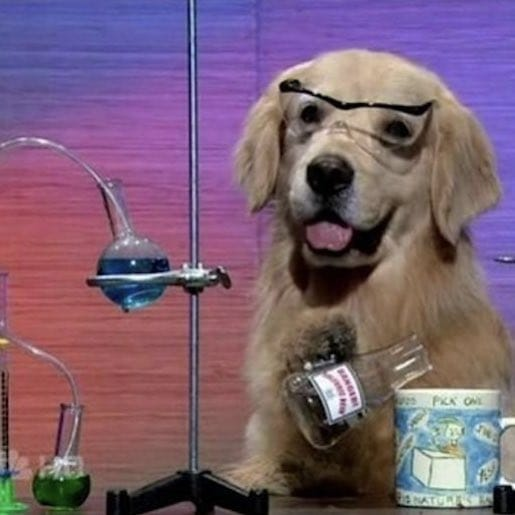

In [65]:
image_path = "./test/perro_ciencia.jpg"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))

Dimensiones de raw image
torch.Size([3, 227, 227])
DImensiones de imagen unsqueeze
torch.Size([1, 3, 227, 227])
Salida de la red
tensor([[ 0.2027, -0.2665, -2.3517,  8.7366,  0.3436, -0.7259, -1.3907, -1.7782,
          0.3105, -3.0810]], device='cuda:0')
Clase predicha
Cat


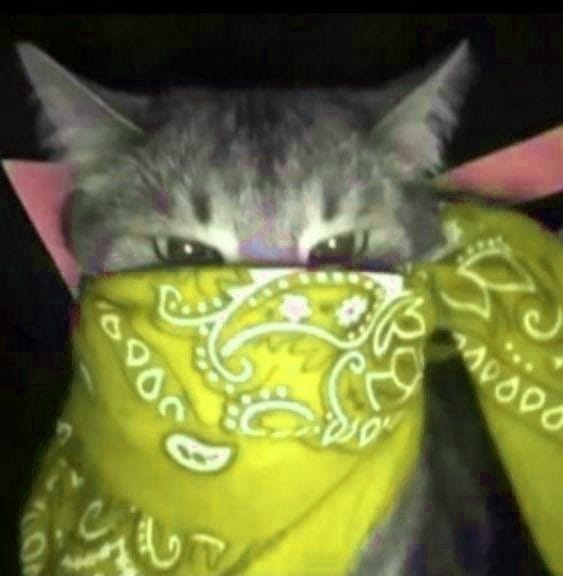

In [68]:
image_path = "./test/tapado.jpg"
predict_class = pre_image(image_path,model_loaded, nombre_clases)
print("Clase predicha")
print(predict_class)
display(Image.open(image_path))